In [1]:
import os
import sys 
import json
import glob
import random
import collections
import time
import re

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional
import torch.nn.functional as F

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


In [2]:
data_directory = '../input/rsna-miccai-brain-tumor-radiogenomic-classification'
pytorch3dpath = "../input/efficientnetpyttorch3d/EfficientNet-PyTorch-3D"
mri_types = ['FLAIR','T1w','T1wCE','T2w']
SIZE = 256
NUM_IMAGES = 64

sys.path.append(pytorch3dpath)
from efficientnet_pytorch_3d import EfficientNet3D

In [3]:
def load_dicom_image(path, img_size=SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
        
    data = cv2.resize(data, (img_size, img_size))
    return data


def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR", split="train", rotate=0):

    files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return np.expand_dims(img3d,0)

a = load_dicom_images_3d("00000")
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))

(1, 256, 256, 64)
0.0 1.0 0.07902179328632788 0.00023671822699371212


In [4]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(12)

In [5]:
train_df = pd.read_csv(f"{data_directory}/train_labels.csv")
display(train_df)

df_train, df_valid = sk_model_selection.train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=12, 
    stratify=train_df["MGMT_value"],
)


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [6]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)
        n_features = self.net._fc.in_features
        self.net._fc = nn.Linear(in_features=n_features, out_features=1, bias=True)
    
    def forward(self, x):
        out = self.net(x)
        return out


In [7]:
class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, label_smoothing=0.01, split="train", augment=False):
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.label_smoothing = label_smoothing
        self.split = split
        self.augment = augment
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        scan_id = self.paths[index]
        if self.targets is None:
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split=self.split)
        else:
            if self.augment:
                rotation = np.random.randint(0,4)
            else:
                rotation = 0

            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split="train", rotate=rotation)

        if self.targets is None:
            return {"X": torch.tensor(data).float(), "id": scan_id}
        else:
            y = torch.tensor(abs(self.targets[index]-self.label_smoothing), dtype=torch.float)
            return {"X": torch.tensor(data).float(), "y": y}


In [8]:
def predict(modelfile, df, mri_type, split):
    print("Predict:", modelfile, mri_type, df.shape)
    df.loc[:,"MRI_Type"] = mri_type
    data_retriever = Dataset(
        df["BraTS21ID"].values, 
        mri_type=df["MRI_Type"].values,
        split=split
    )

    data_loader = torch_data.DataLoader(
        data_retriever,
        batch_size=4,
        shuffle=False,
        num_workers=8,
    )
   
    model = Model()
    model.to(device)
    
    checkpoint = torch.load(modelfile)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    y_pred = []
    ids = []

    for e, batch in enumerate(data_loader,1):
        print(f"{e}/{len(data_loader)}", end="\r")
        with torch.no_grad():
            tmp_pred = torch.sigmoid(model(batch["X"].to(device))).cpu().numpy().squeeze()
            if tmp_pred.size == 1:
                y_pred.append(tmp_pred)
            else:
                y_pred.extend(tmp_pred.tolist())
            ids.extend(batch["id"].numpy().tolist())
            
    preddf = pd.DataFrame({"BraTS21ID": ids, "MGMT_value": y_pred}) 
    preddf = preddf.set_index("BraTS21ID")
    return preddf

Predict: /kaggle/input/mri-models-specific/FLAIR-e10-loss0.680-auc0.624.pth FLAIR (117, 2)


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


,BraTS21ID,MGMT_value,MRI_Type,MGMT_pred
339,502,1,FLAIR,1
292,423,0,FLAIR,0
536,788,0,FLAIR,0
90,138,1,FLAIR,0
54,87,1,FLAIR,1
...,...,...,...,...
495,725,1,FLAIR,1
522,765,1,FLAIR,1
171,253,1,FLAIR,0
43,66,1,FLAIR,1


Accuracy 0.5982905982905983


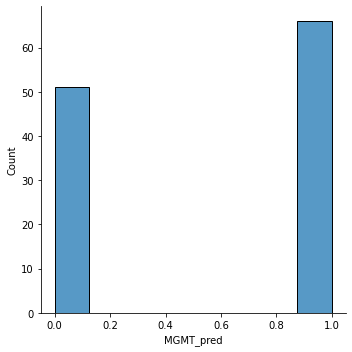

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pred = predict("/kaggle/input/mri-models-specific/FLAIR-e10-loss0.680-auc0.624.pth", df_valid, "FLAIR", "train")
y_pred= pred["MGMT_value"].tolist()
y_pred = [int(np.round(i)) for i in y_pred]
df_valid["MGMT_pred"] =y_pred
display(df_valid)
auc = roc_auc_score(df_valid["MGMT_value"], df_valid["MGMT_pred"])
accuracy = accuracy_score(df_valid["MGMT_value"], df_valid["MGMT_pred"])
print("Accuracy",accuracy)
sns.displot(df_valid["MGMT_pred"])

Predict: /kaggle/input/mri-models-specific/T1w-e6-loss0.691-auc0.581.pth T1w (117, 4)


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


,BraTS21ID,MGMT_value,MRI_Type,MGMT_pred
339,502,1,T1w,1
292,423,0,T1w,1
536,788,0,T1w,1
90,138,1,T1w,1
54,87,1,T1w,1
...,...,...,...,...
495,725,1,T1w,1
522,765,1,T1w,1
171,253,1,T1w,1
43,66,1,T1w,1


Accuracy 0.5299145299145299


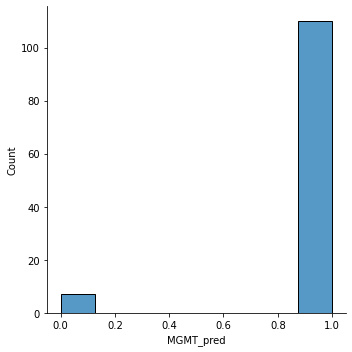

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pred = predict("/kaggle/input/mri-models-specific/T1w-e6-loss0.691-auc0.581.pth", df_valid, "T1w", "train")
y_pred= pred["MGMT_value"].tolist()
y_pred = [int(np.round(i)) for i in y_pred]
df_valid["MGMT_pred"] =y_pred
display(df_valid)
auc = roc_auc_score(df_valid["MGMT_value"], df_valid["MGMT_pred"])
accuracy = accuracy_score(df_valid["MGMT_value"], df_valid["MGMT_pred"])
print("Accuracy",accuracy)
sns.displot(df_valid["MGMT_pred"])

Predict: /kaggle/input/mri-models-specific/T1wCE-e4-loss0.688-auc0.561.pth T1wCE (117, 4)


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


,BraTS21ID,MGMT_value,MRI_Type,MGMT_pred
339,502,1,T1wCE,1
292,423,0,T1wCE,1
536,788,0,T1wCE,1
90,138,1,T1wCE,1
54,87,1,T1wCE,1
...,...,...,...,...
495,725,1,T1wCE,1
522,765,1,T1wCE,1
171,253,1,T1wCE,1
43,66,1,T1wCE,1


Accuracy 0.5470085470085471


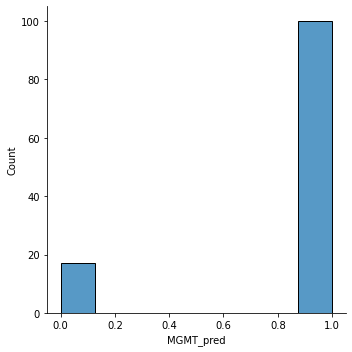

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pred = predict("/kaggle/input/mri-models-specific/T1wCE-e4-loss0.688-auc0.561.pth", df_valid, "T1wCE", "train")
y_pred= pred["MGMT_value"].tolist()
y_pred = [int(np.round(i)) for i in y_pred]
df_valid["MGMT_pred"] =y_pred
display(df_valid)
auc = roc_auc_score(df_valid["MGMT_value"], df_valid["MGMT_pred"])
accuracy = accuracy_score(df_valid["MGMT_value"], df_valid["MGMT_pred"])
print("Accuracy",accuracy)
sns.displot(df_valid["MGMT_pred"])

Predict: /kaggle/input/mri-models-specific/T2w-e10-loss0.690-auc0.577.pth T2w (117, 4)


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


,BraTS21ID,MGMT_value,MRI_Type,MGMT_pred
339,502,1,T2w,1
292,423,0,T2w,0
536,788,0,T2w,0
90,138,1,T2w,0
54,87,1,T2w,1
...,...,...,...,...
495,725,1,T2w,1
522,765,1,T2w,1
171,253,1,T2w,0
43,66,1,T2w,1


Accuracy 0.5811965811965812


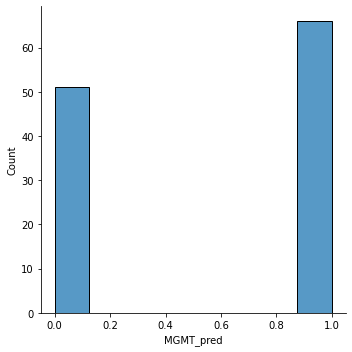

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pred = predict("/kaggle/input/mri-models-specific/T2w-e10-loss0.690-auc0.577.pth", df_valid, "T2w", "train")
y_pred= pred["MGMT_value"].tolist()
y_pred = [int(np.round(i)) for i in y_pred]
df_valid["MGMT_pred"] =y_pred
display(df_valid)
auc = roc_auc_score(df_valid["MGMT_value"], df_valid["MGMT_pred"])
accuracy = accuracy_score(df_valid["MGMT_value"], df_valid["MGMT_pred"])
print("Accuracy",accuracy)
sns.displot(df_valid["MGMT_pred"])